In [1]:
import torch
from torch.utils.data.dataloader import DataLoader as dl
from torch.utils.data import TensorDataset as ds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda:0


In [3]:
class MLP(torch.nn.Module): 
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = torch.nn.Linear(1,80) 
        self.activation1 = torch.nn.ReLU() 
        self.fc2 = torch.nn.Linear(80,1)
        #self.fc3 = torch.nn.Linear(40,1) 

    def forward(self, x): 
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        # x = self.activation1(x)
        # x = self.fc3(x)
        return x

net = MLP()
net.to(device)
print(net) 

MLP(
  (fc1): Linear(in_features=1, out_features=80, bias=True)
  (activation1): ReLU()
  (fc2): Linear(in_features=80, out_features=1, bias=True)
)


In [4]:
datapoints = 200
split_size = 0.9
noise_level =.1
x = torch.randint(-50,50,(datapoints,1)).float()
noise = torch.randn((datapoints,1))
y = (x**2)+(2*x)+ 3 
xavg = x.mean()
xdev = x.std()
yavg = y.mean()
ydev = y.std()
x = (x-xavg)/xdev
y = (y-yavg)/ydev
print(y.shape,noise.shape)
y = y+(noise*noise_level)
# for i in range(len(y)):
#     y[i] = y[i] + noise[i]

torch.Size([200, 1]) torch.Size([200, 1])


In [5]:
print(x.shape)
print(y.shape)

torch.Size([200, 1])
torch.Size([200, 1])


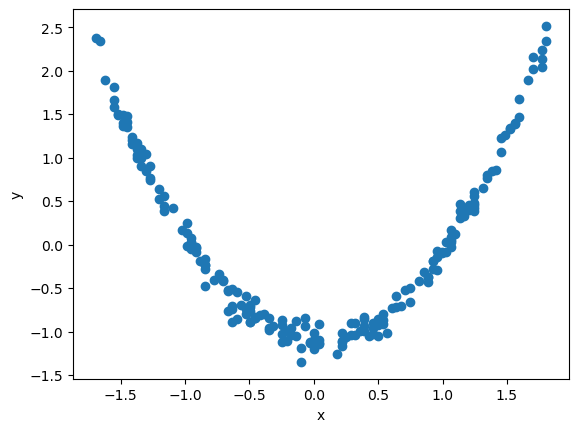

In [6]:

plt.scatter(x,y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [7]:
xtrain, ytrain = x[:int(split_size*datapoints)],y[:int(split_size*datapoints)] 
xtest, ytest = x[int(split_size*datapoints):],y[int(split_size*datapoints):]


xtrain, xval, ytrain,yval = train_test_split(xtrain,ytrain,test_size=0.1,random_state=9,shuffle=True)

trainingset = ds(xtrain,ytrain)
testset = ds(xtest,ytest)
validationset = ds(xval,yval)

trainloader = dl(trainingset,num_workers=16,shuffle=True,batch_size=32)
testloader = dl(testset,num_workers=16,shuffle=False,batch_size=32)
validationloader = dl(validationset,num_workers=16,shuffle=False,batch_size=32)

In [8]:
criteria = torch.nn.MSELoss()
optim = torch.optim.Adam(net.parameters(),lr=0.001)

In [11]:
def train_model(model,criteria,optimizer,dataloader,validation_set_loader,number_epochs:int):
    epochs = []
    training_loss_per_epoch = []
    training_loss_per_batch = []
    validation_loss_per_epoch = []
    validation_loss_per_batch = []
    y_values_for_last_batch=[]
    x_values_for_last_batch=[]
    for epoch in range(number_epochs):
        print(f'epoch number: {epoch}')
        model.train()
        training_losses = []
        for data,label in dataloader:
            optimizer.zero_grad()
            data = data.to(device)
            label = label.to(device)
            outputs = model(data)
            loss = criteria(outputs,label)
            loss.backward()
            optimizer.step()

            training_losses.append(loss.item())
        training_loss_per_batch += training_losses
        training_loss_per_epoch.append(sum(training_losses)/len(training_losses))
        model.eval()
        with torch.no_grad():
            validation_losses=[]
            for data1 ,label1 in validation_set_loader:
                data1 = data1.to(device)
                label1 = label1.to(device)
                valoutputs = model(data1)
                validationloss = criteria(valoutputs,label1)
                validation_losses.append(validationloss.item())
            if (epoch+1 >=number_epochs): #this would preferebly be changed to a tolerance on the Validation loss/ epochs, which ever comes first, can also use the patience condition
                for data3 ,label3 in trainloader:
                    valoutput = model(data3)
                    x_values_for_last_batch.append(data3)
                    y_values_for_last_batch.append(valoutput)
        validation_loss_per_batch += validation_losses
        validation_loss_per_epoch.append(np.array(validation_losses).mean())
        epochs.append(epoch+1)

    return training_loss_per_epoch,training_loss_per_batch,validation_loss_per_epoch,validation_loss_per_batch,y_values_for_last_batch,x_values_for_last_batch,epochs

        

training_loss_per_epoch,training_loss_per_batch,validation_loss_per_epoch,validation_loss_per_batch,y_values_for_last_batch,x_values_for_last_batch,epochs=train_model(model=net,criteria=criteria,optimizer=optim,dataloader=trainloader, validation_set_loader= validationloader,number_epochs=20)


epoch number: 0
epoch number: 1
epoch number: 2
epoch number: 3
epoch number: 4
epoch number: 5
epoch number: 6
epoch number: 7
epoch number: 8
epoch number: 9
epoch number: 10
epoch number: 11
epoch number: 12
epoch number: 13
epoch number: 14
epoch number: 15
epoch number: 16
epoch number: 17
epoch number: 18
epoch number: 19


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

torch.Size([162, 1]) torch.Size([162, 1])


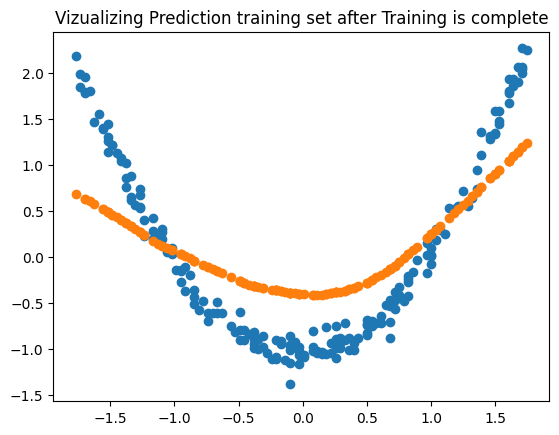

In [ ]:
x_values= torch.concat(x_values_for_last_batch)
y_values = torch.concat(y_values_for_last_batch)
print(x_values.shape,y_values.shape)
plt.scatter(x,y)
plt.scatter(x_values[:,0],y_values[:,0])
plt.title('Vizualizing Prediction training set after Training is complete')
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


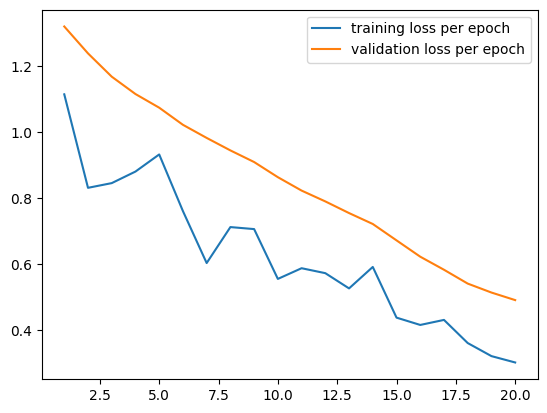

In [10]:
print(epochs)
plt.plot(epochs,training_loss_per_epoch,label='training loss per epoch')
plt.plot(epochs,validation_loss_per_epoch,label='validation loss per epoch')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (120,)

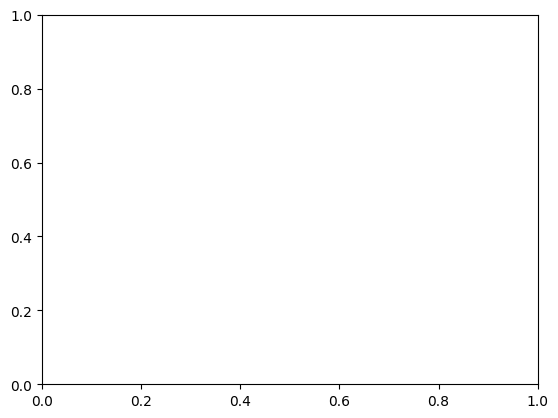

In [14]:
plt.plot(epochs,training_loss_per_batch,label="training loss")
plt.plot(epochs,validation_loss_per_batch,label="validation loss")
plt.xlabel('epochs')
plt.ylabel('loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# guessed = []
# def evaluate_model(model,criterion,dataloader):
#     model.eval()

#     with torch.no_grad():
#         for data ,label in dataloader:
#             outputs = model(data)
#             loss = criterion(outputs,label)
#             guess = (outputs*ydev)+yavg
#             actual = (label*ydev)+yavg
#             print(f'guessed {guess} vs actual {actual} with loss {loss}')
#             guessed.append(outputs)
# evaluate_model(net,criteria,testloader)

In [ ]:
torch.save(net.state_dict(),"polynomial.pth")

In [ ]:
net.load_state_dict(torch.load('polynomial.pth'))

net.eval()

testing_if_loaded_input = torch.randn(80,1)
out = net(testing_if_loaded_input)
print(out)

tensor([[ 1.2853],
        [-1.0874],
        [ 2.1866],
        [-0.9591],
        [-1.0896],
        [-1.0205],
        [-0.8405],
        [-1.0947],
        [-1.0802],
        [-1.0683],
        [-0.1030],
        [-0.6058],
        [ 0.9961],
        [-1.0872],
        [-0.6196],
        [ 1.8238],
        [-0.4594],
        [-1.0833],
        [ 0.2208],
        [-0.9911],
        [-1.0506],
        [-0.6544],
        [-0.1675],
        [-0.7715],
        [-0.2366],
        [ 1.2853],
        [ 1.3599],
        [-1.0941],
        [ 0.3222],
        [ 0.6593],
        [-1.0299],
        [ 0.9290],
        [-0.8780],
        [ 0.3940],
        [ 1.2552],
        [-1.0916],
        [-0.4803],
        [ 0.2652],
        [ 1.1433],
        [ 0.3292],
        [-1.0477],
        [ 0.8831],
        [-1.0135],
        [ 3.0728],
        [-0.9337],
        [ 1.3147],
        [-0.3967],
        [ 2.5252],
        [-0.0658],
        [-0.9812],
        [-0.7929],
        [ 0.4083],
        [-1.

In [ ]:
'''I want to plot the line of best fit after regression. The best way to do that is to compute the outputs on the test set and then plot the line of best fit on the whole set
However, since the last 10 percent is used for the testing, we are basically testing for out of range data? But better to plot after fully training the model, and use the validation set??'''

'I want to plot the line of best fit after regression. The best way to do that is to compute the outputs on the test set and then plot the line of best fit on the whole set\nHowever, since the last 10 percent is used for the testing, we are basically testing for out of range data? But better to plot after fully training the model, and use the validation set??'